## The thinnest mirror in the world: an atomic array
**Language:** julia  

**Packages:** LinearAlgebra, StaticArrays, SpecialFunctions, QuadGK, PythonPlot


The major challenge quantum optics is to realize a efficient light-matter interface. Ideally, the presence of matter has to strongly alter the behavior of light in a coherent way. In this notes we will see why it is challenging and a way to overcome this limitation with atomic arrays, as proposed in [Shamoon2017](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.118.113601).

### 1. A single atom and a single photon
As anticipated, let's consider simplest scenario, the interaction of a single point-like two-level atom and a single photon. The main goal is to visualize how strongly a single atom can affect an incoming realistic laser field.

Under suitable approximation is quantum optics and for the simple case of a single incoming photon, this open system can be captured in terms of a non-Hemitian Hamiltonian which describe the dipole interaction between light and matter as well as spontaneous emission:
$$H_0=\left[\Delta+i\frac{\Gamma_0}{2}\right]\sigma^{j}_{ee} + E_j\sigma_{eg}^{j}+E_j^{*}\sigma_{ge}^{j}$$
Having defined:
- $\Delta$ is the detuning of the laser field with respect to the two-level transition.
- $\Gamma_0$ is the spontaneous emission rate of the atom.
- $E_i=(\mathbf{E}(\mathbf{r}_i)\cdot \hat{\mathbf{x}})d_{eg}/\hbar$ is the Rabi frequency, which depends on the amplitude of the field at the atom's position and on the dipole matrix element $d_{eg}$. 
- $\sigma_{eg}=|e\rangle\langle g|$, for example, is the operator that excite the atom.

While it is pretty well-known that under the influence of a constant field the atom will reach a steady state coherence, $|\psi\rangle=|g\rangle+c|e\rangle$:
$$ c=\langle\sigma_{eg}\rangle= \frac{E_i}{\Delta+i\Gamma_0/2}$$

However, very little is generically discussed about what happen to the field. To understand the effect of the atom on the field we need two ingredients:
- A description of a realistic focused laser field
- An equation to describe the scattered field by the atom

#### a. A realistic laser field
To look at the efficiency of this interaction in a realistic scenario we need a realistic description of the electrical field. The typical choice to capture a laser field that can be found in an experiment is a [Laguerre-Gauss mode](https://en.wikipedia.org/wiki/Gaussian_beam), a solution of the Maxwell equations in the paraxial approximation. An implementation is provided in <code>GaussianBeams.jl</code>.
To define a solution of this kind in 3D, one need to specify some parameters:
1. $w_0$: the beam waist.
2. $P_{f}$: the polarization of the field.
3. $\mathbf{k}$: the k-vector, which describe the direction of propagation.
4. $E_0$: an amplitude.

#### b. The input-output equation
The electrical field will excite the atom absorbing a photon, which, under the its spontaneous emission will be re-emitted. In this open system, we can always reconstruct the total field thanks to an "input-output equation":
$$\mathbf{E}_{tot}=\mathbf{E}_{in}+\mu_0\omega_0^2d_{ge}\sum_j\mathbf{G}_0(\mathbf{r}\!-\!\mathbf{r}_j,\omega_0) \mathbf{\hat{x}} \ c_{j}$$
This equation means that if we know the atomic coherences $c_j=\langle\sigma_{eg}^{j}\rangle$ the average total field is always the sum of the input one (the one we send in), and the scattered field by the atom. 

The scattered part of the field is implemented in <code>SpinModelSingleExcitation.jl</code>.
In particular, the sum run on all the atoms. Here we simply have one, but we will later add more.

Here $\mathbf{G}_0(\mathbf{r}\!-\!\mathbf{r}_j)$ is the Green's tensor, the fundamental solution of the wave equation, which physically describe how the field propagates from $\mathbf{r}_j$ to $\mathbf{r}$. Since it is physically a 3x3 matrix, it is implemented in <code>GreensTensor.jl</code> as a <code>StaticArray</code> object for fast algebra.

Great! We covered everything we needed and we can start to compute. In order we will first define some physical constants and the parameters of the laser beam.



In [7]:
#------------------ATOMIC PARAMS
#position
r=[0.0,0.0,0.0]
#polarization vector
Pa=[1.0,0.0,0.0]
#atomic transition wavevector/wavelenght
k0=1.0
λ0=2pi
#decay rate 
Γ0=1.0

#-------------------FIELD PARAMS
include("./lib/GaussianBeams.jl")
#Gaussian Beam
E0=1.0
#beam waist, it is useful to relate it to λ0~780 nm
w0=2.5λ0
#k vector of the field along z
vk=k0*[0.0,0.0,1.0]
#polarization vector of the field
Pf=[1.0,0.0,0.0]
#detuning of the laser
Δ=0.0
#field type 
ft="Laguerre-Gauss"

"Laguerre-Gauss"

Having defined the physical parameters, we create a field and calculate its effect on the atomic coherence

In [8]:
#include the implementation of the scattered field
include("./lib/SpinModelSingleExcitation.jl")

#Electrical field at atomic positions
E_in=E_at_atoms([r],Pa,E0,Pf,vk,w0,ft)

#evaluate atomic coherence
C=E_in/(Δ+im*Γ0/2);

We will the mesh the space and calculate the total electrical field at each point.

In [9]:
#mesh for evaluating the field
n_mesh=210
x_m=range(-5λ0,stop=5λ0,length=n_mesh)
z_m=range(-10λ0,stop=10λ0,length=n_mesh)

#evaluate the field intensity I(x,z) on the mesh
I_tot=zeros(n_mesh,n_mesh)
for i=1:n_mesh,l=1:n_mesh
	#q: position at which the field is evaluated
	q=[x_m[i],1.8,z_m[l]]
	#input field at q
	E_in=E_Laguerre_Gauss(q,E0,Pf,vk,w0)
	#scattered field at q
	E_sc=E_scatt(q,[r],Pa,C,k0)
	I_tot[i,l]=norm(E_in+E_sc)^2
end

#### Potting the field
Finally, we plot the intensity of the calculated total field. To do so we define a function to plot the field intensity and the atom's position.

We observe that, for realistic parameters, as a consequence of the interaction, the atom scatter the input field. However, this effect is rather small and most of the light pass through without any interaction.

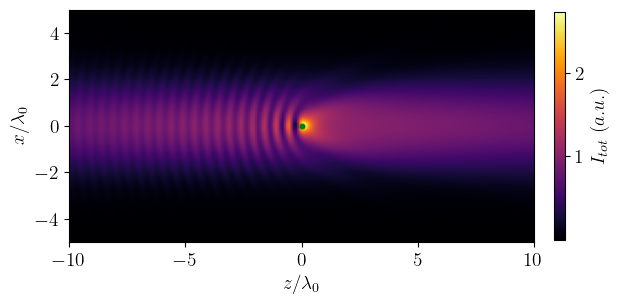

In [10]:
#import matplotlib in Julia
using PythonPlot, LaTeXStrings
#turning off interactive plots
ioff()
#setting rc parameters
rcParams=PythonPlot.matplotlib.rcParams
rcParams["text.usetex"] = true
rcParams["text.latex.preamble"] = "\\usepackage{mathtools,amssymb}"
rcParams["font.size"] = 14

function plot_field_and_atoms(field_intensity,atoms_pos,extent)
#=
function to nicely plot the total field and the atoms
    field_intensity: 2D array of the field intensity
    atoms_pos: list of 3D vectors of atomic positions
    extent: physical size of the plot for imshow()
=#
    fig, ax = subplots(1, 1)

    #plot the field
    em=ax.imshow(field_intensity, 
        #interpolation = "bilinear",
        cmap="inferno",
        extent=extent)
    #plot colorbar
    cbar=colorbar(em, fraction=0.023, pad=0.04,label=L"I_{tot} \ (a.u.)")
    #set lables
    xlabel(L"z/\lambda_0")
    ylabel(L"x/\lambda_0")

    #plot atom's position
    for q in atoms_pos
        ax.scatter(q[3]/λ0,q[1]/λ0,s=11,c="green")
    end
    return fig
end

#plot area
extent= [z_m[1],z_m[end],x_m[1],x_m[end]]/λ0
plot_field_and_atoms(I_tot,[r],extent)

### 2. Atomic array
Can we do better? The idea is to exploit many atoms and collective interference [[Shamoon2017]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.118.113601). If these atoms are arranged in a regular fashion, such as in an array, we might be able to exploit constructive and destructive interference to achieve 100% reflection.
This is really not entirely a new idea since it is well known in classical antenna theory. Arrays of antennas can be used for [beamforming](https://en.wikipedia.org/wiki/Beamforming), currently employed, for example, in 5G technology.

Remember that the quantity that describes how the field propagates from point to point is the Green's function. For this reason it is intuitive that the total Hamiltonian is in the form $H=H_0+H_{dd}$ where the interaction (known as dipole-dipole interaction) between the atoms is given by
$$H_{dd}=-\mu_0\omega_0^2d_{ge}^2\sum_{j\neq\ell}\mathbf{\hat{x}}\cdot\mathbf{G}_0(\mathbf{r}_j-\mathbf{r}_\ell)\mathbf{\hat{x}} \ \sigma_{eg}^{j}\sigma_{ge}^{\ell}$$

As before we want to solve for the atomic coherence in the steady state $|\psi\rangle=|g\rangle+\sum_{j}c_j|e_j\rangle$. It is easy to show that in this case we just need to solve the linear system $\sum_{j}M_{ij}c_j=E_i$
$$M_{ij}=-(\Delta+i\frac{\Gamma_0}{2})\delta_{ij}+\Gamma_0H_{ij}$$
with
$$H_{ij}=-\frac{3\pi}{k_0}\sum_{i\neq j}\mathbf{\hat{x}}\cdot\mathbf{G}_0(\mathbf{r}_j-\mathbf{r}_\ell)\mathbf{\hat{x}}$$


This last matrix is implemented in <code>SpinModelSingleExcitation.jl</code>.

Finally, we need some routines to build atomic arrays, ideally as a list of 3D vectors that characterize the atomic positions. 
Since in my PhD I studied many lattice configurations, I collected some routines for various crystal configurations in <code>Lattices.jl</code>.

Below, we thus create a 2D array of atoms, compute the atomic coherences and the total electrical field as before. We will observe strong constructive interference in reflection while destructive one in transmission. 

In [14]:
#library to create atomic arrays in 3D
include("./lib/Lattices.jl")

#--------create a 2D array of atoms on (x,y)
#number of atoms
n=26
#lattice constant, d<λ0 to be subwavelenght
d=0.2*λ0
#cener of the array
z0=[0.0,0.0,0.0]
#cubic lattice array
z=CubicP(z0,d,n,n,1);

#build the single excitation Hamiltonian
H=H_1e(z,k0,Pa)

#build the matrix M
M= -(Δ+0.5*im*Γ0)*I + Γ0*H

#Electrical field at atomic positions
E_in=E_at_atoms(z,Pa,E0,Pf,vk,w0,ft)

#find the coherences, solution of the linear system E=Mc, c=M^{-1}E_in
c=M\E_in

#evaluate the total field intensity I(x,z) on the mesh
I_tot_array=zeros(n_mesh,n_mesh)
for i=1:n_mesh,l=1:n_mesh
	#q: position at which the field is evaluated
	q=[x_m[i],0.0,z_m[l]]
	#input field at q
	E_in=E_Laguerre_Gauss(q,E0,Pf,vk,w0)
	#scattered field at q
	E_sc=E_scatt(q,z,Pa,c,k0)
	I_tot_array[i,l]=norm(E_in+E_sc)^2
end

3×3 SMatrix{3, 3, ComplexF64, 9} with indices SOneTo(3)×SOneTo(3):
 -0.0407499+0.0376599im      -0.0+0.0im              0.0+0.0im
       -0.0+0.0im        0.120637+0.045133im        -0.0+0.0im
        0.0+0.0im            -0.0+0.0im       -0.0407499+0.0376599im

Finally we can plot to see how light scatter from an array of atoms.

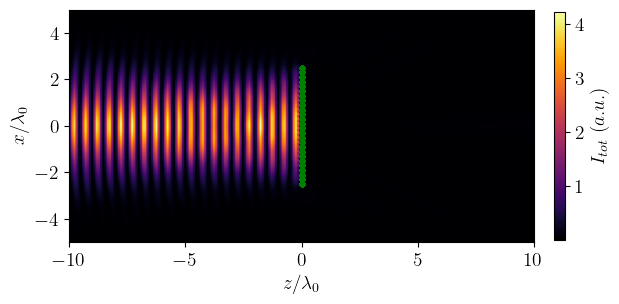

In [12]:
#reuse plot function defined before
plot_field_and_atoms(I_tot_array,z,extent)

Great! Nearly 100% reflection, this is the thinnest mirror in the world, just made with a 2D array of atoms and exploiting collective interference.

100% reflection also implies nearly 100% coherent interaction. This high efficiency can be used for example to realize efficient [quantum memories]() or [gates](). Recently, this idea has also been tested [experimentally](https://www.nature.com/articles/s41586-020-2463-x), reaching nearly 60% reflection. 